In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from deepchem.molnet import load_hiv, load_tox21, load_bace_classification, load_sider, load_clintox, load_bbbp
from hdpy.metrics import compute_roc_enrichment
import seaborn as sns
sns.set_style("whitegrid")


# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

from tqdm import tqdm
from pathlib import Path

# RANDOM_SEED=5
# RANDOM_SEED=99
# RANDOM_SEED=101
RANDOM_SEED=109
output_result_dir = Path(f"/p/vast1/jones289/hd_results/{RANDOM_SEED}")

green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
red_color_pal = sns.color_palette("Reds", 10)
purple_color_pal = sns.color_palette("Purples", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

plot_dict = {
        "RPFP": ("HDB-RPFP", red_color_pal[4]),
        "Combo": ("HDB-Combo", purple_color_pal[5]),
        #   "HDBind (10k) (GPU-no encode)": green_color_pal[8],
        "MoLFormer": ("HDB-MoLFormer", green_color_pal[7]),
        # "MoLFormer+RPFP": ("HDB Combo", green_color_pal[9]),
        "MolCLR": ("HDB-MolCLR", green_color_pal[4]),
        "DECFP-4": ("HDB-DECFP", red_color_pal[8]),
        "DECFP-4-Tani": ("HDB-DECFP-Tani", blue_color_pal[4]),
        "MLP": ("MLP", "black"),
    }


d_to_idx_map = {"1k": 1000,
                "10k": 10000,
                "100k": 100000,
                "1m": 1000000,
                "20k": 20000,
                "50k": 50000,
                "200k": 200000,
                "500k": 500000,
                "16384": 16384}

# define the values of D instead so I don't have to enumerate this extensively...
# d_list = [1000, 10000, 100000, 1000000, 16384, 20000, 50000, 200000, 500000]
# model_name_map = {
'''

'''
model_name_map ={
    "logreg": ("Log. Reg. (L2)", 1024),
    "mlp-1024-1": ("MLP-1024", 1024),
    # "mlp-2048-1": ("MLP-2048", 2048),
    # "hdbind-rp-molformer-1k": ("HDB-MoLFormer", 1000),
    # "hdbind-rp-molformer": ("HDB-MoLFormer", 10000),
    # "hdbind-rp-molformer-100k": ("HDB-MoLFormer", 100000),
    # "hdbind-rp-molformer-1m": ("HDB-MoLFormer", 1000000),
    # "hdbind-rp-molformer-20k": ("HDB-MoLFormer", 20000),
    # "hdbind-rp-molformer-50k": ("HDB-MoLFormer", 50000),
    # "hdbind-rp-molformer-200k": ("HDB-MoLFormer", 200000),
    # "hdbind-rp-molformer-500k": ("HDB-MoLFormer", 500000),

    "hdbind-directecfp-tanimoto-16384-1": ("HDB-DECFP-Tani", 16384),
    "hdbind-directecfp-16384-1": ("HDB-DECFP", 16384),

    # "hdbind-directecfp-16384-2": ("HDB-DECFP", 16384),
    # "hdbind-directecfp-16384-4": ("HDB-DECFP", 16384),
    # "hdbind-molformer-decfp-combo-1k": ("HDB-Combo", 1000),
    # "hdbind-molformer-decfp-combo-100k": ("HDB-Combo", 100000),
    # "hdbind-molformer-decfp-combo-1m": ("HDB-Combo", 1000000),
    # "hdbind-molformer-decfp-combo": ("HDB-Combo", 10000),
    # "hdbind-molformer-decfp-combo-20k": ("HDB-Combo", 20000),
    # "hdbind-molformer-decfp-combo-50k": ("HDB-Combo", 50000),
    # "hdbind-molformer-decfp-combo-200k": ("HDB-Combo", 200000),
    # "hdbind-molformer-decfp-combo-500k": ("HDB-Combo", 500000),
    # "hdbind-rp-ecfp-1024-1-1k": ("HDB-RPFP", 1000),
    # "hdbind-rp-ecfp-1024-1": ("HDB-RPFP", 10000),
    # "hdbind-rp-ecfp-1024-1-100k": ("HDB-RPFP", 100000),
    # "hdbind-rp-ecfp-1024-1-1m": ("HDB-RPFP", 1000000),
    # "hdbind-rp-ecfp-1024-1-20k": ("HDB-RPFP", 20000),
    # "hdbind-rp-ecfp-1024-1-50k": ("HDB-RPFP", 50000),
    # "hdbind-rp-ecfp-1024-1-200k": ("HDB-RPFP", 200000),
    # "hdbind-rp-ecfp-1024-1-500k": ("HDB-RPFP", 500000),
    # "hdbind-rp-molclr-1k": ("HDB-MolCLR", 1000),
    # "hdbind-rp-molclr": ("HDB-MolCLR", 10000),
    # "hdbind-rp-molclr-100k": ("HDB-MolCLR", 100000),
    # "hdbind-rp-molclr-1m": ("HDB-MolCLR", 1000000),
    # "hdbind-rp-molclr-20k": ("HDB-MolCLR", 20000),
    # "hdbind-rp-molclr-50k": ("HDB-MolCLR", 50000),
    # "hdbind-rp-molclr-200k": ("HDB-MolCLR", 200000),
    # "hdbind-rp-molclr-500k": ("HDB-MolCLR", 500000),
    # "hdbind-directecfp-1k-1": ("HDB-DECFP", 1000),
    # "hdbind-directecfp-1k-2": ("HDB-DECFP", 1000),
    # "hdbind-directecfp-1k-4": ("HDB-DECFP", 1000),
    # "hdbind-directecfp-10k-1": ("HDB-DECFP", 10000),
    # "hdbind-directecfp-10k-2": ("HDB-DECFP", 10000),
    # "hdbind-directecfp-10k-4": ("HDB-DECFP", 10000),
    # "hdbind-directecfp-100k-1": ("HDB-DECFP", 100000),
    # "hdbind-directecfp-100k-2": ("HDB-DECFP", 100000),
    # "hdbind-directecfp-100k-4": ("HDB-DECFP", 100000),
    # "hdbind-directecfp-1m-1": ("HDB-DECFP", 1000000),
    # "hdbind-directecfp-1m-2": ("HDB-DECFP", 1000000),
    # "hdbind-directecfp-1m-4": ("HDB-DECFP", 1000000),
    # "hdbind-directecfp-20k-1": ("HDB-DECFP", 20000),
    # "hdbind-directecfp-20k-2": ("HDB-DECFP", 20000),
    # "hdbind-directecfp-20k-4": ("HDB-DECFP", 20000),
    # "hdbind-directecfp-50k-1": ("HDB-DECFP", 50000),
    # "hdbind-directecfp-50k-2": ("HDB-DECFP", 50000),
    # "hdbind-directecfp-50k-4": ("HDB-DECFP", 50000),
    # "hdbind-directecfp-200k-1": ("HDB-DECFP", 200000),
    # "hdbind-directecfp-200k-2": ("HDB-DECFP", 200000),
    # "hdbind-directecfp-200k-4": ("HDB-DECFP", 200000),
    # "hdbind-directecfp-500k-1": ("HDB-DECFP", 500000),
    # "hdbind-directecfp-500k-2": ("HDB-DECFP", 500000),
    # "hdbind-directecfp-500k-4": ("HDB-DECFP", 500000),
}
'''


'''
# }





'\n\n\n'

In [2]:
def collect_metrics(dataset:str, split:str, config_list:list, verbose=False):

    result_dict = {
                    "model": [],
                    "D": [],
                    "target": [],
                    "seed": [],
                    "roc-auc": [],
                    "er-1": [],
                #    "train_time": [],
                #    "test_time": [],
                    "path": [],
                    "train_time_cpu_sum": [],
                    "train_time_cpu_norm": [],
                    "train_time_cuda_sum": [],
                    "train_time_cuda_norm": [],
                   
                    "test_time_cpu_sum": [],
                    "test_time_cpu_norm": [],
                    "test_time_cuda_sum": [],
                    "test_time_cuda_norm": [],
                   }

    target_list = []
    if dataset in ["bbbp", "tox21", "clintox", "hiv", "bace", "sider"]:
        if dataset == "bbbp":
            data = load_bbbp()
        if dataset == "tox21":
            data = load_tox21()
        if dataset == "clintox":
            data = load_clintox(splitter="scaffold")
        if dataset == "hiv":
            data = load_hiv()
        if dataset == "bace":
            data = load_bace_classification()
        if dataset == "sider":
            data = load_sider()

        target_list = data[0]
    elif dataset == "lit-pcba":
        lit_pcba_ave_p = Path("/p/vast1/jones289/lit_pcba/AVE_unbiased")
        target_list = [x.name for x in list(lit_pcba_ave_p.glob("*/"))]

    # print(target_list)
    for config_path in tqdm(config_list):
        exp_name = config_path.stem
        if verbose:
            tqdm.write(f"{config_path}, {exp_name}")

        # '''
         # '''
        # for d in range(10):       
        if exp_name.split(".")[0] in model_name_map:
            
            for target_name in target_list:
                
                result_file = Path(
                    f"{output_result_dir}/{exp_name}.{dataset}-{target_name.replace(' ','_')}-{split}.{RANDOM_SEED}.pkl"
                )
                try:
                    if verbose:
                        tqdm.write(f"loading {result_file}")
                    data = torch.load(result_file)
                except FileNotFoundError as e:
                    tqdm.write(f"{e}. {result_file} does not exist.")
                    continue


                # print(data.keys())
                for random_state in data["trials"].keys():

                    result_dict["path"].append(result_file)
                    result_dict["model"].append(model_name_map[exp_name][0])
                    # result_dict["D"].append(data["args"].D)
                    result_dict["D"].append(model_name_map[exp_name][1])
                    result_dict["target"].append(target_name)
                    result_dict["seed"].append(random_state)
                    result_dict["roc-auc"].append(data["trials"][random_state]["roc-auc"])


                    # extract timing information
                    if "mlp" in model_name_map[exp_name][0].lower():
                
                        train_time_cpu_sum = 0.0
                        for time_key in ["train_forward_time_cpu_sum", "train_loss_time_cpu_sum", "train_backward_time_cpu_sum"]:
                            train_time_cpu_sum += data["trials"][random_state][time_key] 

                        result_dict["train_time_cpu_sum"].append(train_time_cpu_sum)


                        train_time_cpu_norm = 0.0
                        for time_key in ["train_forward_time_cpu_norm", "train_loss_time_cpu_norm", "train_backward_time_cpu_norm"]:
                            train_time_cpu_norm += data["trials"][random_state][time_key]

                        result_dict["train_time_cpu_norm"].append(train_time_cpu_norm)


                        train_time_cuda_sum = 0.0
                        for time_key in ["train_forward_time_cuda_sum", "train_loss_time_cuda_sum", "train_backward_time_cuda_sum"]:
                            train_time_cuda_sum += data["trials"][random_state][time_key]

                        result_dict["train_time_cuda_sum"].append(train_time_cuda_sum)


                        train_time_cuda_norm = 0.0
                        for time_key in ["train_forward_time_cuda_norm", "train_loss_time_cuda_norm", "train_backward_time_cuda_norm"]:
                            train_time_cuda_norm += data["trials"][random_state][time_key]

                        result_dict["train_time_cuda_norm"].append(train_time_cuda_norm)

                        # add testing information


                        result_dict["test_time_cpu_sum"].append(data["trials"][random_state]["test_forward_time_cpu_sum"])
                        result_dict["test_time_cpu_norm"].append(data["trials"][random_state]["test_forward_time_cpu_norm"])
                        result_dict["test_time_cuda_sum"].append(data["trials"][random_state]["test_forward_time_cuda_sum"])
                        result_dict["test_time_cuda_norm"].append(data["trials"][random_state]["test_forward_time_cuda_norm"])

                    elif "logreg" in exp_name.lower():

                        result_dict["train_time_cpu_sum"].append(np.nan)
                        result_dict["train_time_cpu_norm"].append(np.nan)
                        result_dict["train_time_cuda_sum"].append(np.nan)
                        result_dict["train_time_cuda_norm"].append(np.nan)


                        result_dict["test_time_cpu_sum"].append(np.nan)
                        result_dict["test_time_cpu_norm"].append(np.nan)
                        result_dict["test_time_cuda_sum"].append(np.nan)
                        result_dict["test_time_cuda_norm"].append(np.nan)


                    else:

                        train_time_cpu_sum = 0.0
                        for time_key in ["am_time_cpu_sum", "retrain_time_cpu_sum"]:
                            train_time_cpu_sum += data["trials"][random_state][time_key] 
                        result_dict["train_time_cpu_sum"].append(train_time_cpu_sum)


                        train_time_cpu_norm = 0.0
                        for time_key in ["am_time_cpu_norm", "retrain_time_cpu_norm"]:
                            train_time_cpu_norm += data["trials"][random_state][time_key]
                        result_dict["train_time_cpu_norm"].append(train_time_cpu_norm)


                        train_time_cuda_sum = 0.0
                        for time_key in ["am_time_cuda_sum", "retrain_time_cuda_sum"]:
                            train_time_cuda_sum += data["trials"][random_state][time_key] 
                        result_dict["train_time_cuda_sum"].append(train_time_cuda_sum)


                        train_time_cuda_norm = 0.0
                        for time_key in ["am_time_cuda_norm", "retrain_time_cuda_norm"]:
                            train_time_cuda_norm += data["trials"][random_state][time_key]
                        result_dict["train_time_cuda_norm"].append(train_time_cuda_norm)


                        result_dict["test_time_cpu_sum"].append(data["trials"][random_state]["test_time_cpu_sum"])
                        result_dict["test_time_cuda_sum"].append(data["trials"][random_state]["test_time_cuda_sum"])

                        result_dict["test_time_cpu_norm"].append(data["trials"][random_state]["test_time_cpu_norm"])
                        result_dict["test_time_cuda_norm"].append(data["trials"][random_state]["test_time_cuda_norm"])



                    # compute er-1 metric or load saved value
                    try:
                        
                        er_1 = data["trials"][random_state]["er-1"]
                        result_dict["er-1"].append(er_1)

                    except KeyError as e:
                        
                        if verbose: 
                            tqdm.write(f"{e}. result missing roc-enrichment metrics. computing these now.")
                        for trial_idx in data["trials"].keys():
                            scores = None 
                            
                            if "er-1" not in data["trials"][trial_idx].keys():

                                # if config.model in ["molehd-bpe", "selfies","hdbind-directecfp-10k-4",
                                                    # "hdbind-molformer-decfp-combo",
                                                    #   "ecfp", "rp", "directecfp"]:
                                    # scores = model_data_dict["trials"][trial_idx]["eta"]
                                if "mlp" in exp_name.lower():
                                    scores = data["trials"][trial_idx]["eta"][:, 1]
                                else:

                                    scores = data["trials"][trial_idx]["eta"]
                                
                                labels = data["trials"][trial_idx]['y_true']

                                #TODO: allow for a list of fp_thresh to be computed
                                trial_er_1 = compute_roc_enrichment(scores=scores, labels=labels, fpr_thresh=.01)

                                data["trials"][trial_idx]["er-1"] = trial_er_1
                

    
                        er_1 = data["trials"][random_state]["er-1"]
                        result_dict["er-1"].append(er_1)
    # import pdb
    # pdb.set_trace()
    return pd.DataFrame(result_dict)

In [3]:
def get_metric_df(config_list: list, split:str, use_cache=True, verbose=False):
    assert split in ["ave", "random"]

    metric_df = None
    metric_df_path = Path(f"{split}-metric-df_backup.csv")
    if use_cache:
        metric_df = pd.read_csv(metric_df_path, index_col=0)
    else:
        metric_df = collect_metrics(dataset="lit-pcba", split=split, 
                                        config_list=config_list,
                                        verbose=verbose)
        metric_df.to_csv(metric_df_path)

    return metric_df


In [4]:
# config_dir = "roc_auc_configs_final"
config_dir = "roc_auc_configs_revise"
ave_metric_df = get_metric_df(config_list=list(Path(f"/usr/WS1/jones289/hd-cuda-master/hdpy/{config_dir}").glob("*.yml")),
                                split="ave", 
                                use_cache=False,
                                verbose=True)
ave_metric_df

  0%|          | 0/72 [00:00<?, ?it/s]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/mlp-1024-1.yml, mlp-1024-1
loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-ADRB2-ave.109.pkl


  0%|          | 0/72 [00:00<?, ?it/s]

loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-ALDH1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-ESR1_ago-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-ESR1_ant-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-FEN1-ave.109.pkl


  0%|          | 0/72 [00:00<?, ?it/s]

loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-GBA-ave.109.pkl


  0%|          | 0/72 [00:00<?, ?it/s]

loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-IDH1-ave.109.pkl


  0%|          | 0/72 [00:01<?, ?it/s]

loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-KAT2A-ave.109.pkl


  0%|          | 0/72 [00:01<?, ?it/s]

loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-MAPK1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-MTORC1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-OPRK1-ave.109.pkl


  0%|          | 0/72 [00:01<?, ?it/s]

loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-PKM2-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-PPARG-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-TP53-ave.109.pkl


  1%|▏         | 1/72 [00:02<02:32,  2.14s/it]

loading /p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-VDR-ave.109.pkl


  1%|▏         | 1/72 [00:02<02:32,  2.14s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/logreg.yml, logreg
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-ADRB2-ave.109.pkl


  1%|▏         | 1/72 [00:02<02:32,  2.14s/it]

loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-ALDH1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-ESR1_ago-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-ESR1_ant-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-FEN1-ave.109.pkl


  1%|▏         | 1/72 [00:02<02:32,  2.14s/it]

loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-GBA-ave.109.pkl


  1%|▏         | 1/72 [00:03<02:32,  2.14s/it]

loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-IDH1-ave.109.pkl


  1%|▏         | 1/72 [00:03<02:32,  2.14s/it]

loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-KAT2A-ave.109.pkl


  1%|▏         | 1/72 [00:03<02:32,  2.14s/it]

loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-MAPK1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-MTORC1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-OPRK1-ave.109.pkl


  1%|▏         | 1/72 [00:04<02:32,  2.14s/it]

loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-PKM2-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-PPARG-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-TP53-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/logreg.lit-pcba-VDR-ave.109.pkl


  3%|▎         | 2/72 [00:04<02:27,  2.11s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/mlp-2048-1.yml, mlp-2048-1
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-100k-1.yml, hdbind-directecfp-100k-1
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-100k-2.yml, hdbind-directecfp-100k-2
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-100k-4.yml, hdbind-directecfp-100k-4
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-molformer-decfp-combo-100k.yml, hdbind-molformer-decfp-combo-100k
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-ecfp-1024-1-100k.yml, hdbind-rp-ecfp-1024-1-100k
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-molclr-100k.yml, hdbind-rp-molclr-100k
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-molformer-100k.yml, hdbind-rp-molformer-100k
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-molformer-ecf

  3%|▎         | 2/72 [00:04<02:27,  2.11s/it]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-ALDH1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-ESR1_ago-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-ESR1_ant-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-FEN1-ave.109.pkl


  3%|▎         | 2/72 [00:04<02:27,  2.11s/it]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-GBA-ave.109.pkl


  3%|▎         | 2/72 [00:05<02:27,  2.11s/it]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-IDH1-ave.109.pkl


  3%|▎         | 2/72 [00:05<02:27,  2.11s/it]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-KAT2A-ave.109.pkl


  3%|▎         | 2/72 [00:05<02:27,  2.11s/it]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-MAPK1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-MTORC1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-OPRK1-ave.109.pkl


  3%|▎         | 2/72 [00:06<02:27,  2.11s/it]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-PKM2-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-PPARG-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-TP53-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-tanimoto-16384-1.lit-pcba-VDR-ave.109.pkl


 76%|███████▋  | 55/72 [00:06<00:01, 11.73it/s]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-1k-1.yml, hdbind-directecfp-1k-1
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-1k-2.yml, hdbind-directecfp-1k-2
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-1k-4.yml, hdbind-directecfp-1k-4
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-16384-1.yml, hdbind-directecfp-16384-1
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-ADRB2-ave.109.pkl


 76%|███████▋  | 55/72 [00:06<00:01, 11.73it/s]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-ALDH1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-ESR1_ago-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-ESR1_ant-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-FEN1-ave.109.pkl


 76%|███████▋  | 55/72 [00:06<00:01, 11.73it/s]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-GBA-ave.109.pkl


 76%|███████▋  | 55/72 [00:07<00:01, 11.73it/s]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-IDH1-ave.109.pkl


 76%|███████▋  | 55/72 [00:07<00:01, 11.73it/s]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-KAT2A-ave.109.pkl


 76%|███████▋  | 55/72 [00:07<00:01, 11.73it/s]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-MAPK1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-MTORC1-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-OPRK1-ave.109.pkl


 76%|███████▋  | 55/72 [00:08<00:01, 11.73it/s]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-PKM2-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-PPARG-ave.109.pkl
loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-TP53-ave.109.pkl


 82%|████████▏ | 59/72 [00:08<00:01,  7.96it/s]

loading /p/vast1/jones289/hd_results/109/hdbind-directecfp-16384-1.lit-pcba-VDR-ave.109.pkl
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-16384-2.yml, hdbind-directecfp-16384-2
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-16384-4.yml, hdbind-directecfp-16384-4
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-10k-1.yml, hdbind-directecfp-10k-1
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-10k-2.yml, hdbind-directecfp-10k-2
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-directecfp-10k-4.yml, hdbind-directecfp-10k-4
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-molclr.yml, hdbind-rp-molclr
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-molclr-1m.yml, hdbind-rp-molclr-1m


100%|██████████| 72/72 [00:08<00:00,  8.58it/s]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-molclr-1k.yml, hdbind-rp-molclr-1k
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-ecfp-1024-1-1m.yml, hdbind-rp-ecfp-1024-1-1m
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-ecfp-1024-1-1k.yml, hdbind-rp-ecfp-1024-1-1k
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-ecfp-1024-1.yml, hdbind-rp-ecfp-1024-1
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-molformer-1m.yml, hdbind-rp-molformer-1m
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_revise/hdbind-rp-molformer-1k.yml, hdbind-rp-molformer-1k


,model,D,target,seed,roc-auc,er-1,path,train_time_cpu_sum,train_time_cpu_norm,train_time_cuda_sum,train_time_cuda_norm,test_time_cpu_sum,test_time_cpu_norm,test_time_cuda_sum,test_time_cuda_norm
0,MLP-1024,1024,ADRB2,0,0.748944,0.000000,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,27.286549,0.000012,24.921095,0.000011,0.339566,0.000004,0.300572,0.000004
1,MLP-1024,1024,ALDH1,0,0.719909,7.068452,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,9.029241,0.000011,8.187597,0.000010,0.115916,0.000004,0.101849,0.000004
2,MLP-1024,1024,ESR1_ago,0,0.510872,0.000000,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,0.814048,0.000019,0.769621,0.000018,0.008766,0.000006,0.007583,0.000005
3,MLP-1024,1024,ESR1_ant,0,0.523266,4.000000,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,0.432769,0.000011,0.393453,0.000010,0.005667,0.000004,0.004586,0.000004
4,MLP-1024,1024,FEN1,0,0.894830,27.173913,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,30.604345,0.000011,27.853174,0.000010,0.381406,0.000004,0.336645,0.000004
5,MLP-1024,1024,GBA,0,0.679379,14.634146,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,24.637561,0.000011,22.376687,0.000010,0.338034,0.000005,0.298048,0.000004
6,MLP-1024,1024,IDH1,0,0.566174,0.000000,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,31.385010,0.000012,28.579165,0.000011,0.392744,0.000004,0.346452,0.000004
7,MLP-1024,1024,KAT2A,0,0.614411,6.250000,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,29.046779,0.000011,26.412977,0.000010,0.377177,0.000004,0.332667,0.000004
8,MLP-1024,1024,MAPK1,0,0.635793,2.798533,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,8.910855,0.000019,8.424793,0.000018,0.069509,0.000004,0.061043,0.000004
9,MLP-1024,1024,MTORC1,0,0.525026,0.000000,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,1.867959,0.000008,1.619553,0.000007,0.024818,0.000003,0.020280,0.000002


In [5]:
ave_metric_df["D"].unique()

array([ 1024, 16384])

In [6]:
random_metric_df = get_metric_df(config_list=list(Path(f"/usr/WS1/jones289/hd-cuda-master/hdpy/{config_dir}").glob("*.yml")),
                                    split="random", 
                                    use_cache=False)
random_metric_df

100%|██████████| 72/72 [00:07<00:00,  9.02it/s]


,model,D,target,seed,roc-auc,er-1,path,train_time_cpu_sum,train_time_cpu_norm,train_time_cuda_sum,train_time_cuda_norm,test_time_cpu_sum,test_time_cpu_norm,test_time_cuda_sum,test_time_cuda_norm
0,MLP-1024,1024,ADRB2,0,0.637172,0.000000,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,26.037954,0.000011,23.664418,0.000010,0.327935,0.000004,0.289162,0.000004
1,MLP-1024,1024,ALDH1,0,0.773641,11.681548,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,9.568013,0.000012,8.723315,0.000011,0.123110,0.000005,0.108682,0.000004
2,MLP-1024,1024,ESR1_ago,0,0.139924,0.000000,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,0.659845,0.000016,0.615884,0.000015,0.007528,0.000005,0.006441,0.000005
3,MLP-1024,1024,ESR1_ant,0,0.586095,0.943415,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,0.754377,0.000020,0.715213,0.000019,0.008082,0.000006,0.007025,0.000006
4,MLP-1024,1024,FEN1,0,0.922403,44.565217,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,30.654488,0.000011,27.921483,0.000010,0.378761,0.000004,0.335196,0.000004
5,MLP-1024,1024,GBA,0,0.798109,47.619048,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,33.973839,0.000015,31.706593,0.000014,0.257154,0.000003,0.220508,0.000003
6,MLP-1024,1024,IDH1,0,0.500006,1.000011,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,51.347929,0.000019,48.598094,0.000018,0.436182,0.000005,0.386720,0.000004
7,MLP-1024,1024,KAT2A,0,0.634479,14.285714,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,29.246702,0.000011,26.596825,0.000010,0.357267,0.000004,0.314854,0.000004
8,MLP-1024,1024,MAPK1,0,0.679327,14.285714,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,5.183823,0.000011,4.706556,0.000010,0.061855,0.000004,0.054225,0.000003
9,MLP-1024,1024,MTORC1,0,0.540770,4.166667,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,2.850646,0.000011,2.598130,0.000010,0.037200,0.000004,0.032893,0.000004


In [7]:
ave_metric_df.loc[:, "path"][0]

PosixPath('/p/vast1/jones289/hd_results/109/mlp-1024-1.lit-pcba-ADRB2-ave.109.pkl')

In [8]:
ave_metric_df.groupby(["model", "D"]).describe()

seed                                    roc-auc  \
                     count mean  std  min  25%  50%  75%  max   count   
model          D                                                        
HDB-DECFP      16384  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15.0   
HDB-DECFP-Tani 16384  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15.0   
Log. Reg. (L2) 1024   15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15.0   
MLP-1024       1024   15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15.0   

                                ... test_time_cuda_sum            \
                          mean  ...                75%       max   
model          D                ...                                
HDB-DECFP      16384  0.615848  ...           0.212031  0.270846   
HDB-DECFP-Tani 16384  0.487716  ...           0.308195  0.356317   
Log. Reg. (L2) 1024   0.696891  ...                NaN       NaN   
MLP-1024       1024   0.631011  ...           0.299310  0.346452   

                     test_time_cuda_norm                                    \
                                   count      mean           std       min   
model          D                                                             
HDB-DECFP      16384                15.0  0.000003  1.668999e-07  0.000002   
HDB-DECFP-Tani 16384                15.0  0.000004  2.703243e-07  0.000004   
Log. Reg. (L2) 1024                  0.0       NaN           NaN       NaN   
MLP-1024       1024                 15.0  0.000004  9.634228e-07  0.000002   

                                                              
                           25%       50%       75%       max  
model          D                                              
HDB-DECFP      16384  0.000003  0.000003  0.000003  0.000003  
HDB-DECFP-Tani 16384  0.000004  0.000004  0.000004  0.000005  
Log. Reg. (L2) 1024        NaN       NaN       NaN       NaN  
MLP-1024       1024   0.000004  0.000004  0.000004  0.000006  

[4 rows x 88 columns]

In [9]:
random_metric_df.groupby(["model", "D"]).describe()

seed                                    roc-auc  \
                     count mean  std  min  25%  50%  75%  max   count   
model          D                                                        
HDB-DECFP      16384  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15.0   
HDB-DECFP-Tani 16384  15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15.0   
Log. Reg. (L2) 1024   15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15.0   
MLP-1024       1024   15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15.0   

                                ... test_time_cuda_sum            \
                          mean  ...                75%       max   
model          D                ...                                
HDB-DECFP      16384  0.674630  ...           0.222684  0.260183   
HDB-DECFP-Tani 16384  0.523625  ...           0.305704  0.373938   
Log. Reg. (L2) 1024   0.778875  ...                NaN       NaN   
MLP-1024       1024   0.652051  ...           0.279069  0.386720   

                     test_time_cuda_norm                                    \
                                   count      mean           std       min   
model          D                                                             
HDB-DECFP      16384                15.0  0.000003  2.386309e-07  0.000003   
HDB-DECFP-Tani 16384                15.0  0.000004  2.934879e-07  0.000004   
Log. Reg. (L2) 1024                  0.0       NaN           NaN       NaN   
MLP-1024       1024                 15.0  0.000004  8.289255e-07  0.000002   

                                                              
                           25%       50%       75%       max  
model          D                                              
HDB-DECFP      16384  0.000003  0.000003  0.000003  0.000003  
HDB-DECFP-Tani 16384  0.000004  0.000004  0.000004  0.000005  
Log. Reg. (L2) 1024        NaN       NaN       NaN       NaN  
MLP-1024       1024   0.000004  0.000004  0.000004  0.000006  

[4 rows x 88 columns]

In [10]:
mlp_1024_mean_rocauc_random = (random_metric_df[random_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).mean()["roc-auc"].values

mlp_1024_mean_rocauc_ave = (ave_metric_df[ave_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).mean()["roc-auc"].values

mlp_1024_mean_er1_ave = (ave_metric_df[ave_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).mean()["er-1"].values

# mlp_1024_median_test_time_ave = (ave_metric_df[ave_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).median()["test_time"].values

In [11]:
(ave_metric_df[ave_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).median()

,,seed,roc-auc,er-1,train_time_cpu_sum,train_time_cpu_norm,train_time_cuda_sum,train_time_cuda_norm,test_time_cpu_sum,test_time_cpu_norm,test_time_cuda_sum,test_time_cuda_norm
model,D,,,,,,,,,,,
MLP-1024,1024,0.0,0.627154,3.676471,21.314866,0.000011,19.391737,0.00001,0.168222,0.000004,0.137813,0.000004


In [12]:
(ave_metric_df[ave_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).max()

,,target,seed,roc-auc,er-1,path,train_time_cpu_sum,train_time_cpu_norm,train_time_cuda_sum,train_time_cuda_norm,test_time_cpu_sum,test_time_cpu_norm,test_time_cuda_sum,test_time_cuda_norm
model,D,,,,,,,,,,,,,
MLP-1024,1024,VDR,0,0.89483,27.173913,/p/vast1/jones289/hd_results/109/mlp-1024-1.li...,31.38501,0.000019,28.579165,0.000018,0.392744,0.000007,0.346452,0.000006


In [13]:
# mlp_1024_mean_rocauc_random

In [14]:
model_dict = {
    "MoleHD-BPE": rocket_color_pal[4],
    "HDB-RPFP": green_color_pal[0],
    "HDB-DECFP": green_color_pal[3],
    "HDB-DECFP-Tani": blue_color_pal[3],
    "HDB-MolCLR": green_color_pal[5],
    "HDB-MoLFormer": green_color_pal[7],
    "HDB-Combo": green_color_pal[9],
    # "MLP-1024": blue_color_pal[7],
    "MLP-1024": red_color_pal[7],
    "Log. Reg. (L2)": red_color_pal[9],
    # "Vina": ("Vina", "salmon"),
}

model_order_dict = {
    "HDB-RPFP": 0,
    "HDB-DECFP": 1,
    "HDB-DECFP-Tani":2,
    "HDB-MolCLR": 3,
    "HDB-MoLFormer": 4,
    "HDB-Combo": 5,
    "MLP-1024": 6,
    "Log. Reg. (L2)": 7,
    # "HDB-MolCLR": 2,
    # "HDB-MoLFormer": 3,
    # "HDB-Combo": 4,
    # "MLP-1024": 5,
    }



def make_plot(df, ax, metric):
    # print(df.head())
    df = df.sort_values(by='model', key=lambda x: x.map(model_order_dict))

    width=0.8
    gap=0.2

    sns.boxenplot(data=df, 
            x="D", y=metric, 
            hue="model", 
            ax=ax,
            # order=model_order_list,
            palette={x: model_dict[x] for x in model_dict.keys()},
            width=width, 
            gap=gap
            )
    
def make_roc_auc_plot():
    f,ax = plt.subplots(2,1, figsize=(16,20), sharex=True, sharey=True)

    alpha=0.7

    make_plot(df=random_metric_df[random_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax[0], metric="roc-auc")

    make_plot(df=ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax[1], metric="roc-auc")
    ax[0].set_ylabel("ROC-AUC")
    ax[1].set_ylabel("")

    ax[0].set_title("Random", fontsize=18)
    ax[1].set_title("AVE", fontsize=18)


    # ax[0].get_legend().remove()

    handles, labels = ax[1].get_legend_handles_labels()
    # handles.append(ax[1].axhline(mlp_1024_mean_rocauc_ave, color="red", linestyle="--", alpha=alpha))
    # labels.append("MLP ($\mu$)")
    ax[1].legend(handles,labels, fontsize="x-large", loc="best")
    ax[0].set_xlabel("HDC Dimension $D$", fontsize=20)
    ax[1].set_xlabel("HDC Dimension $D$", fontsize=20)

    hline_zorder=None
    best_model_score_random = random_metric_df[random_metric_df["model"].apply(lambda x: "mlp" not in x.lower() and "log" not in x.lower())].groupby(["model", "D"])["roc-auc"].median().max()
    best_model_score_ave = ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower() and "log" not in x.lower())].groupby(["model", "D"])["roc-auc"].median().max()
    print(best_model_score_random, best_model_score_ave)

    handles,labels = ax[0].get_legend_handles_labels()
    handles.append(ax[0].axhline(y=best_model_score_random, color="blue", linestyle="--",zorder=hline_zorder))
    labels.append("Best HDBind (Median)")
    handles.append(ax[0].axhline(mlp_1024_mean_rocauc_random, color="red", linestyle="--", alpha=alpha))
    labels.append("MLP ($\mu$)")
    handles.append(ax[0].axhline(y=0.5, color="red", linestyle=":", zorder=hline_zorder))
    labels.append("Random")
    ax[0].legend(handles,labels, fontsize="x-large", loc="best")


    # ax[0].legend(handles,labels, fontsize="x-large", loc="best")


    handles,labels = ax[1].get_legend_handles_labels()
    handles.append(ax[1].axhline(y=best_model_score_ave, color="blue", linestyle="--", zorder=hline_zorder))
    labels.append("Best HDBind (Median)")
    handles.append(ax[1].axhline(mlp_1024_mean_rocauc_ave, color="red", linestyle="--", alpha=alpha))
    labels.append("MLP ($\mu$)")
    handles.append(ax[1].axhline(y=0.5, color="red", linestyle=":", zorder=hline_zorder))
    labels.append("Random")
    ax[1].legend(handles,labels, fontsize="x-large", loc="best")

    plt.tight_layout()
    plt.savefig("lit-pcba-rocauc-boxenplot.png", dpi=450)
    
def make_er1_plot():
    f,ax = plt.subplots(1,1, figsize=(16,8), sharex=True, sharey=True)


    make_plot(df=ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax, metric="er-1")
    ax.set_ylabel("")

    ax.set_title("AVE", fontsize=18)

    alpha=0.7
    handles, labels = ax.get_legend_handles_labels()
    handles.append(ax.axhline(4.78, color="red", linestyle="--", alpha=alpha))
    labels.append("GRIM ($\mu$)")
    handles.append(ax.axhline(3.46, color="darkred", linestyle="-.", alpha=alpha))
    labels.append("Pafnucy ($\mu$)")

    handles.append(ax.axhline(mlp_1024_mean_er1_ave, color="red", linestyle=":", linewidth=3, alpha=alpha))
    labels.append("MLP ($\mu$)")

    ax.legend(handles,labels, fontsize="x-large", loc="best")
    ax.set_xlabel("HDC Dimension $D$", fontsize=20)

    plt.tight_layout()
    plt.savefig("lit-pcba-er1-boxenplot.png", dpi=450)



from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import matplotlib.colors as mcolors

def make_ttest_plot(metric="roc-auc", mult_alpha=0.05, method="simes-hochberg"):
    f,ax = plt.subplots(1,1, figsize=(9,8), sharex=True, sharey=True)


    
    heat_map_dict = {"p-value": [],
                    "model": [],
                    "D": [],
                    "index": []}

    ground_truth_df_1024 = ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp-1024" in x.lower())]
    ground_truth_df_2048 = ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp-2048" in x.lower())]

    # print("MLP-1024", ground_truth_df_1024)
    # print("MLP-2048", ground_truth_df_2048)
    for (model, D), group_df in ave_metric_df.groupby(["model", "D"]):
        # print(group, group_df)

        try:
            pvalue = ttest_rel(group_df[metric], ground_truth_df_1024[metric]).pvalue
            print(group_df[metric].shape, ground_truth_df_1024[metric].shape)
            # print(group, pvalue)
            heat_map_dict["model"].append(model)
            heat_map_dict["D"].append(D)
            heat_map_dict["index"].append(f"{model}-{D}")
            heat_map_dict["p-value"].append(pvalue)
        except Exception as e:
            print(e)


    print(heat_map_dict["p-value"])    
    
    heat_map_df = pd.DataFrame(heat_map_dict)
    heat_map_df = heat_map_df[heat_map_df["model"].apply(lambda x: "mlp" not in x.lower())]
    reject, p_values_correct, _, _ = multipletests(heat_map_df["p-value"], method=method, alpha=mult_alpha)


    heat_map_df["corr-p-value"] = p_values_correct
    
    # log_cmap = mcolors.LogNorm(vmin=0.05, vmax=1)
    heat_map_df = heat_map_df.pivot(index="model", columns="D", values="corr-p-value")

    # gax = sns.heatmap(heat_map_df, ax=ax, cmap="coolwarm_r",annot=True, vmin=0.05, vmax=0.05)
    gax = sns.heatmap(heat_map_df, ax=ax, cmap="coolwarm_r",annot=True, vmin=mult_alpha, vmax=mult_alpha)
    # gax = sns.heatmap(heat_map_df, ax=ax, vmin=0, vmax=0.05, cmap="coolwarm_r",annot=True)
    gax.set_ylabel("")

    metric_str_map = {"roc-auc": "ROC-AUC",
                        "er-1": "ER-1%"}
    title_str = f"Statistical significance of {metric_str_map[metric]} ({method}, $\\alpha$={mult_alpha})"
    f.suptitle(title_str)

    plt.tight_layout()

    

    out_str = f"{metric}-{method}-{mult_alpha}"
    plot_path = Path(f"stat_sig_plots/{out_str}-heatmap.png")
    if not plot_path.exists():
        plot_path.parent.mkdir(exist_ok=True)
    print(plot_path)
    plt.savefig(plot_path, dpi=450)
    plt.show()







def make_time_plot(split:str):

    mlp_1024_median_test_time_ave = (ave_metric_df[ave_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).median()[split].values
    f, ax = plt.subplots(1,1, figsize=(16,8), sharex=True, sharey=True)

    # make_plot(df=ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
    make_plot(df=ave_metric_df,
          ax=ax, metric=f"{split}")

    ax.set_yscale("log")
    ax.set_ylabel(f"{split.capitalize()} time (s/mol)")
    ax.legend().set_title(None)

    alpha=0.7
    handles, labels = ax.get_legend_handles_labels()
    handles.append(ax.axhline(mlp_1024_median_test_time_ave, color="red", linestyle="--", alpha=alpha))
    labels.append("MLP")

    best_model_time_ave = ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower())].groupby(["model", "D"])[f"{split}"].median().min()
    handles.append(ax.axhline(best_model_time_ave, color="blue", linestyle="--", alpha=alpha))
    labels.append("HDBind Best")

    ax.legend(handles,labels, fontsize="x-large", loc="best")
    ax.set_title(f"LIT-PCBA AVE {split.capitalize()} Set Latency", fontsize=18)
    plt.tight_layout()
    plt.savefig(f"lit-pcba-{split.lower()}-time-boxenplot.png", dpi=450)


In [15]:

def ttest_main(metric="roc-auc"):

    for alpha in [0.05, .025, .01]:
        for method in ["bonferroni", "holm", "simes-hochberg"]:
            make_ttest_plot(metric=metric, mult_alpha=alpha, method=method)

# ttest_main(metric="roc-auc")
# ttest_main(metric="er-1")


In [16]:
ave_metric_df.columns

Index(['model', 'D', 'target', 'seed', 'roc-auc', 'er-1', 'path',
       'train_time_cpu_sum', 'train_time_cpu_norm', 'train_time_cuda_sum',
       'train_time_cuda_norm', 'test_time_cpu_sum', 'test_time_cpu_norm',
       'test_time_cuda_sum', 'test_time_cuda_norm'],
      dtype='object')

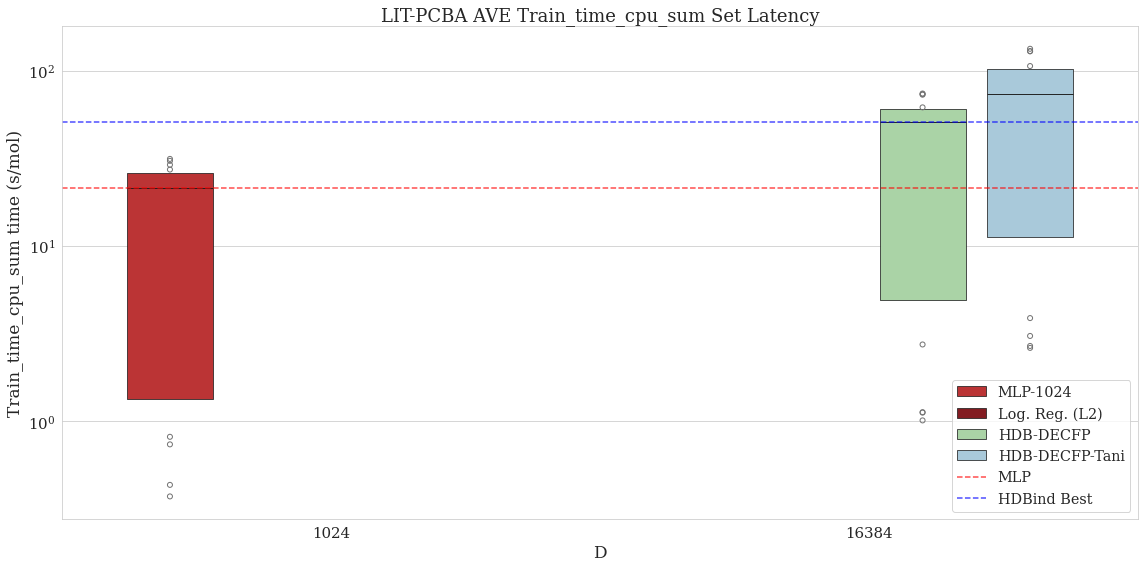

In [17]:
make_time_plot(split="train_time_cpu_sum")

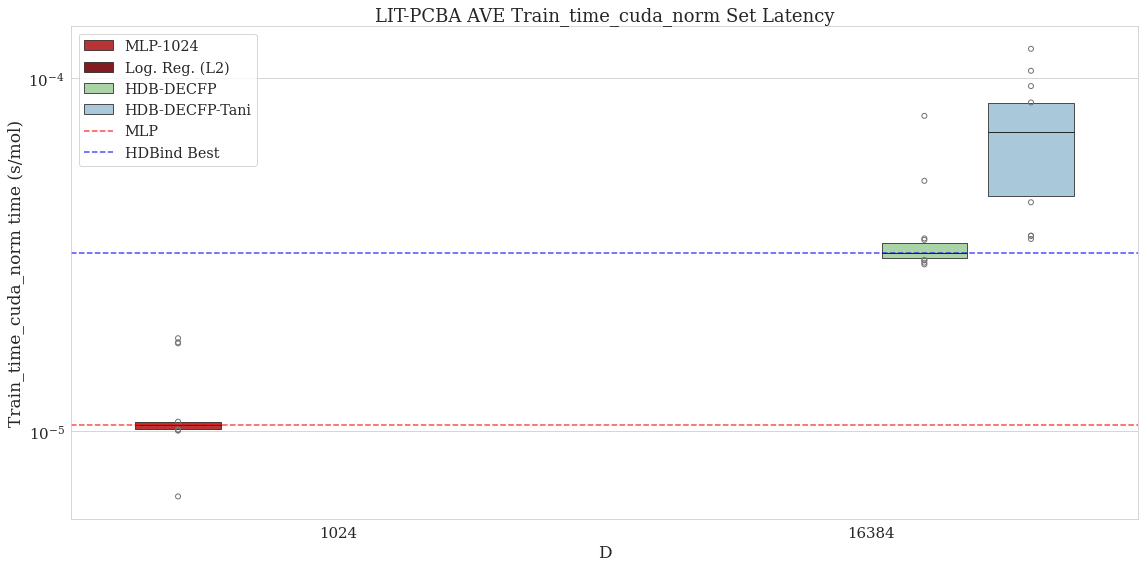

In [18]:
make_time_plot(split="train_time_cuda_norm")

In [19]:
ave_metric_df.loc[:, ["train_time_cuda_norm"]]

,train_time_cuda_norm
0,0.000011
1,0.000010
2,0.000018
3,0.000010
4,0.000010
5,0.000010
6,0.000011
7,0.000010
8,0.000018
9,0.000007


In [20]:
for col in ["train_time_cuda_sum", "train_time_cuda_norm", 
            "train_time_cpu_sum", "train_time_cpu_norm", 
            "test_time_cuda_sum", "test_time_cuda_norm",
            "test_time_cpu_sum", "test_time_cpu_norm"]:
    # print(col, ave_metric_df.groupby(["model", "D"])[:, [x for x in ave_metric_df.columns if "time" in x]].describe())
    print(col, ave_metric_df.groupby(["model", "D"])[[x for x in ave_metric_df.columns if "time" in x]].describe())

train_time_cuda_sum                      train_time_cpu_sum                                  \
                                  count       mean        std       min   
model          D                                                          
HDB-DECFP      16384               15.0  37.879087  29.785351  1.009780   
HDB-DECFP-Tani 16384               15.0  65.921683  50.132565  2.619056   
Log. Reg. (L2) 1024                 0.0        NaN        NaN       NaN   
MLP-1024       1024                15.0  15.479774  12.506420  0.371865   

                                                                    \
                            25%        50%         75%         max   
model          D                                                     
HDB-DECFP      16384   4.936225  51.108545   60.374777   74.110465   
HDB-DECFP-Tani 16384  11.233993  73.621021  102.004980  133.427374   
Log. Reg. (L2) 1024         NaN        NaN         NaN         NaN   
MLP-1024       1024    1.341004  2

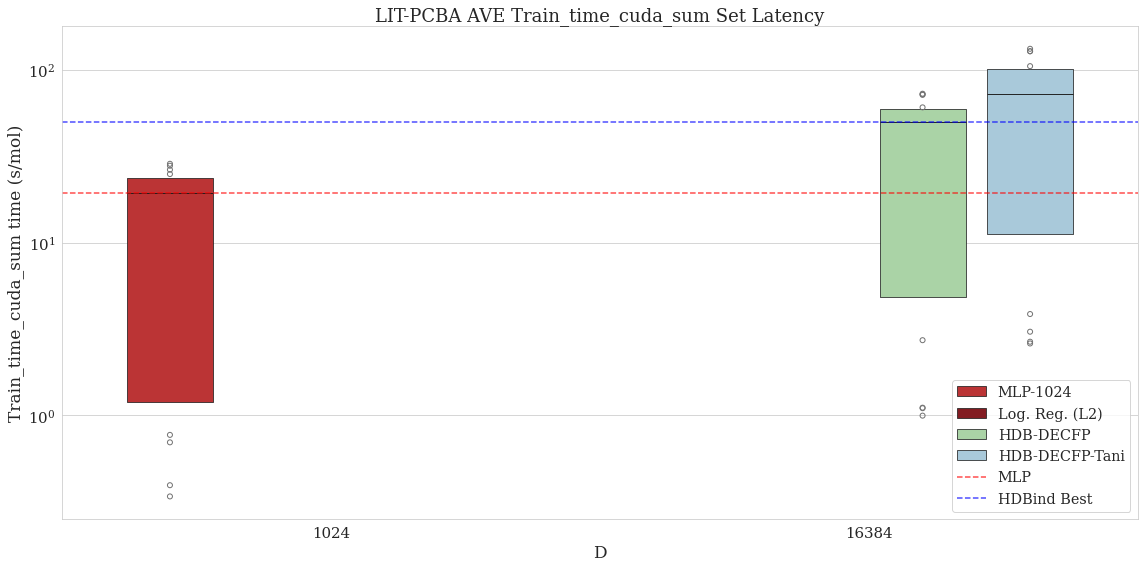

In [21]:
make_time_plot(split="train_time_cuda_sum")

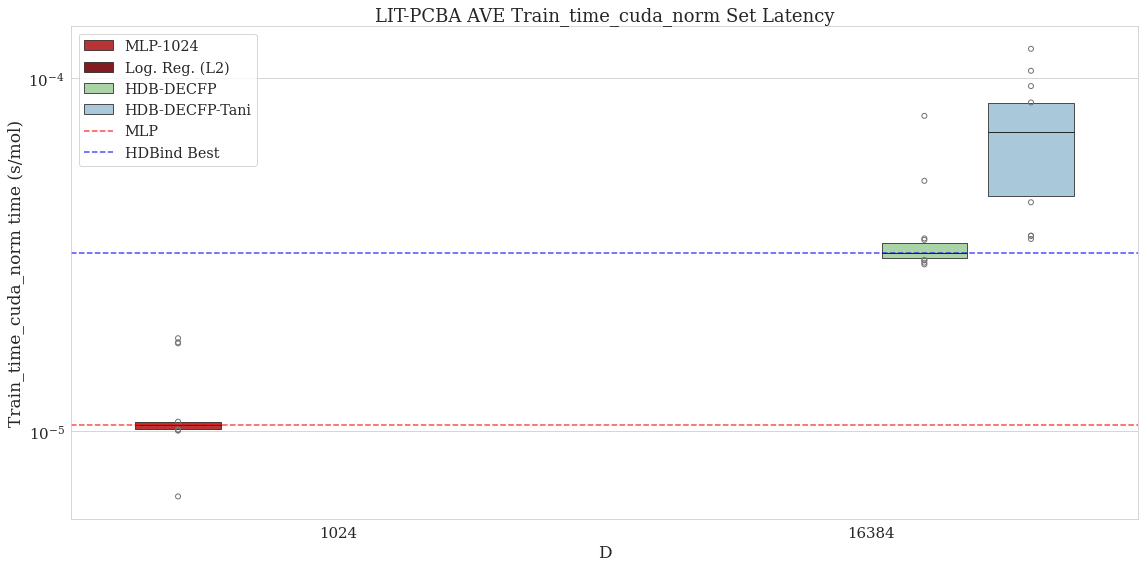

In [28]:

make_time_plot(split="train_time_cuda_norm")

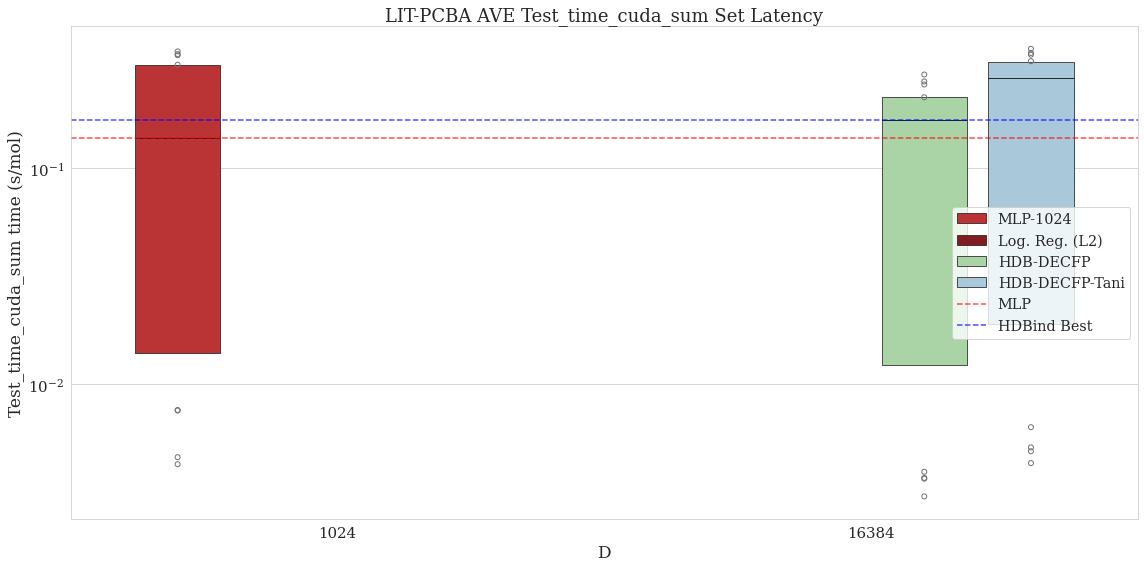

In [22]:
make_time_plot(split="test_time_cuda_sum")

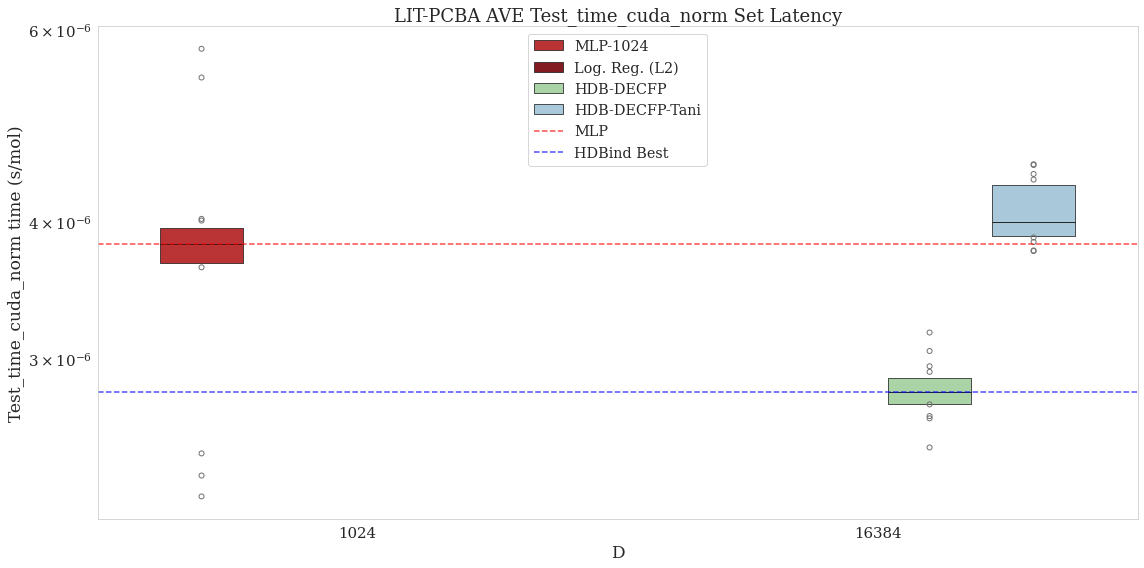

In [23]:

make_time_plot(split="test_time_cuda_norm")

0.6895970614994229 0.6326596604688763


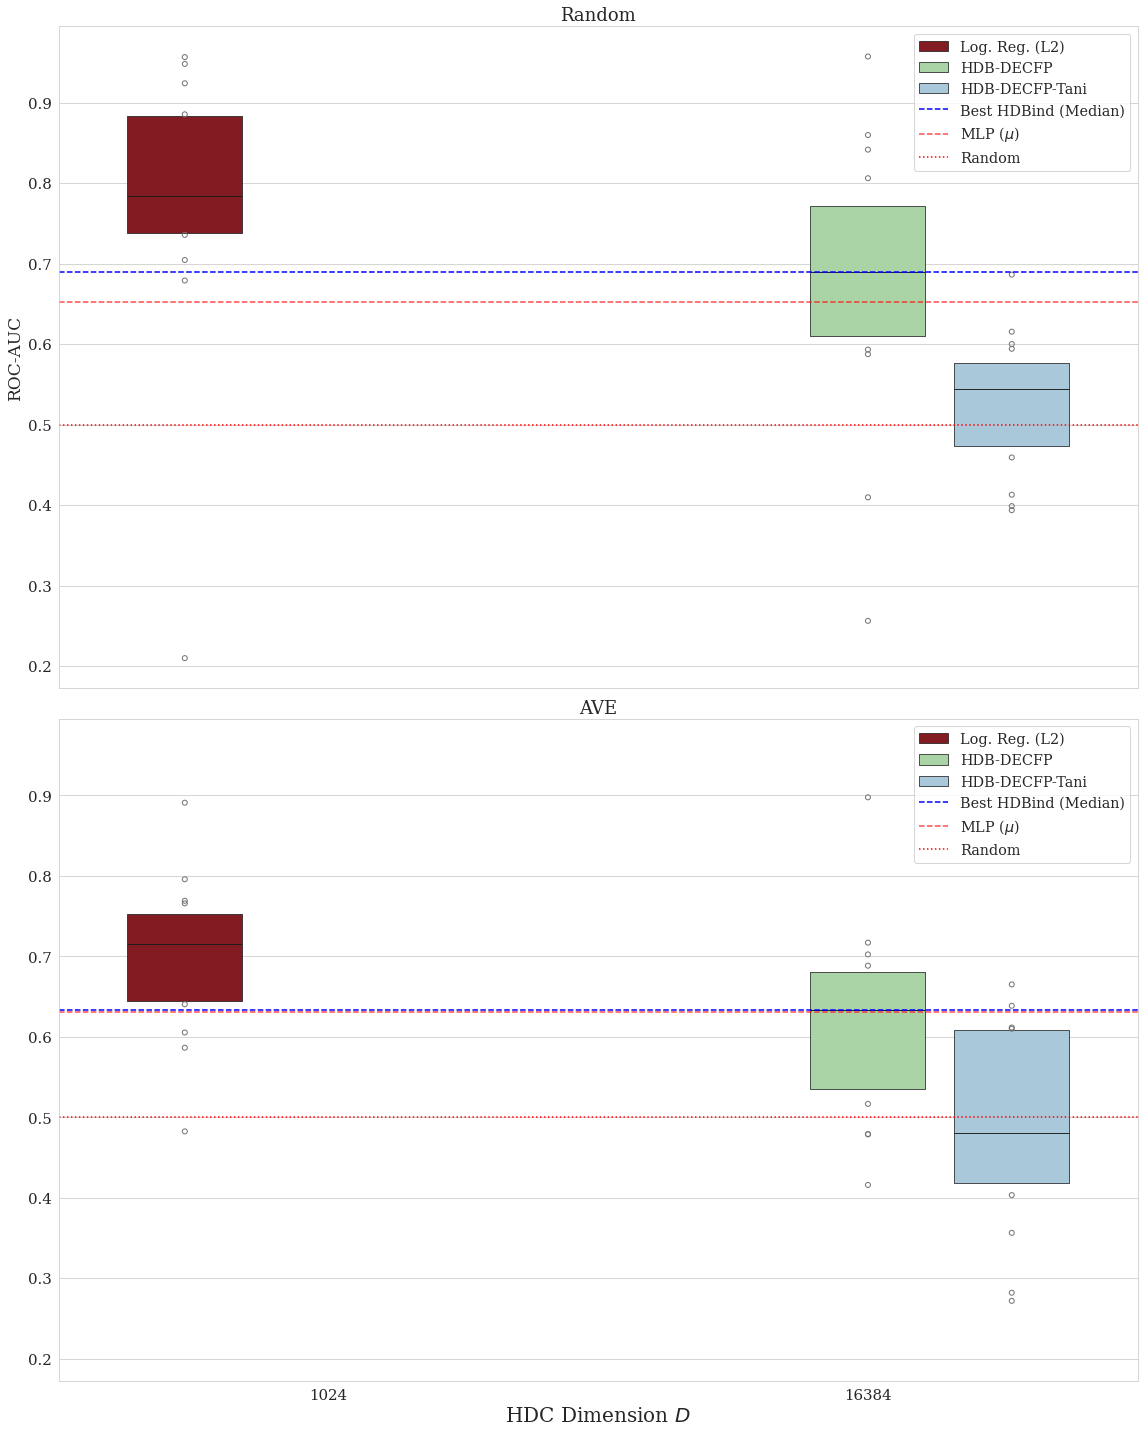

In [29]:
make_roc_auc_plot()

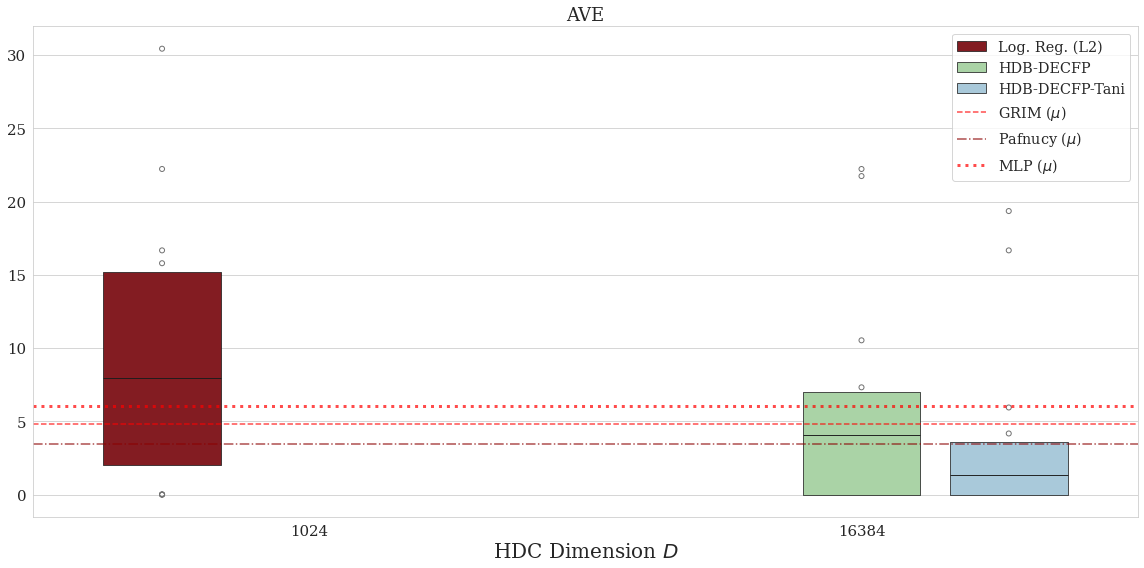

In [25]:
make_er1_plot()

In [26]:
ave_metric_df['target'].unique()

array(['ADRB2', 'ALDH1', 'ESR1_ago', 'ESR1_ant', 'FEN1', 'GBA', 'IDH1',
       'KAT2A', 'MAPK1', 'MTORC1', 'OPRK1', 'PKM2', 'PPARG', 'TP53',
       'VDR'], dtype=object)

In [27]:
lit_pcba_summary_df = pd.read_csv("/g/g13/jones289/workspace/hd-cuda-master/notebooks/lit-pcba-dataset-overview.csv")
merge_df = pd.merge(ave_metric_df, lit_pcba_summary_df, left_on="target", right_on="Set")


# merge_df
# paper_df = merge_df[merge_df["D"] > 10000].groupby(["model", 'D', 'target']).describe()[['roc-auc', 'er-1']].round(2)
paper_df = merge_df[merge_df["D"] > 10000].groupby(["model", 'D', 'target']).describe().round(2)


mask_cols = [x for x in paper_df.columns if x[1] in ["mean", "std", "min", "max"]]
paper_df = paper_df.loc[:, mask_cols]
mask_cols = [x for x in paper_df.columns if x[0] in ["roc-auc", "er-1", "Actives"]]
paper_df = paper_df.loc[:, mask_cols]
# print(paper_df.columns)
mask_cols = [x for x in paper_df.columns if x[0] != "Actives" or x[0] == "Actives" and x[1] not in ["std", "min", "max"]]
paper_df = paper_df.loc[:, mask_cols]
# paper_df.to_csv("lit-pcba-by-target-metrics.csv")
paper_df.to_latex("lit-pcba-by-target-metrics.tex")
paper_df

/var/tmp/jones289/ipykernel_623789/582430755.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  paper_df.to_latex("lit-pcba-by-target-metrics.tex")


roc-auc                   er-1                    \
                               mean std   min   max   mean std    min    max   
model          D     target                                                    
HDB-DECFP      16384 ADRB2     0.48 NaN  0.48  0.48   0.00 NaN   0.00   0.00   
                     ALDH1     0.65 NaN  0.65  0.65   4.09 NaN   4.09   4.09   
                     FEN1      0.90 NaN  0.90  0.90  21.74 NaN  21.74  21.74   
                     GBA       0.67 NaN  0.67  0.67   7.32 NaN   7.32   7.32   
                     IDH1      0.72 NaN  0.72  0.72  22.22 NaN  22.22  22.22   
                     KAT2A     0.59 NaN  0.59  0.59   6.25 NaN   6.25   6.25   
                     MAPK1     0.64 NaN  0.64  0.64   3.90 NaN   3.90   3.90   
                     MTORC1    0.55 NaN  0.55  0.55   4.17 NaN   4.17   4.17   
                     OPRK1     0.42 NaN  0.42  0.42   0.00 NaN   0.00   0.00   
                     PKM2      0.70 NaN  0.70  0.70   3.68 NaN   3.68   3.68   
                     PPARG     0.52 NaN  0.52  0.52   0.00 NaN   0.00   0.00   
                     TP53      0.61 NaN  0.61  0.61  10.53 NaN  10.53  10.53   
                     VDR       0.69 NaN  0.69  0.69   6.67 NaN   6.67   6.67   
HDB-DECFP-Tani 16384 ADRB2     0.61 NaN  0.61  0.61   0.00 NaN   0.00   0.00   
                     ALDH1     0.50 NaN  0.50  0.50   1.37 NaN   1.37   1.37   
                     FEN1      0.67 NaN  0.67  0.67  19.35 NaN  19.35  19.35   
                     GBA       0.48 NaN  0.48  0.48   2.44 NaN   2.44   2.44   
                     IDH1      0.27 NaN  0.27  0.27   0.00 NaN   0.00   0.00   
                     KAT2A     0.48 NaN  0.48  0.48   4.17 NaN   4.17   4.17   
                     MAPK1     0.51 NaN  0.51  0.51   1.30 NaN   1.30   1.30   
                     MTORC1    0.46 NaN  0.46  0.46   0.00 NaN   0.00   0.00   
                     OPRK1     0.28 NaN  0.28  0.28  16.67 NaN  16.67  16.67   
                     PKM2      0.61 NaN  0.61  0.61   2.94 NaN   2.94   2.94   
                     PPARG     0.36 NaN  0.36  0.36   0.00 NaN   0.00   0.00   
                     TP53      0.61 NaN  0.61  0.61   0.00 NaN   0.00   0.00   
                     VDR       0.64 NaN  0.64  0.64   5.94 NaN   5.94   5.94   

                            Actives  
                               mean  
model          D     target          
HDB-DECFP      16384 ADRB2     17.0  
                     ALDH1   5363.0  
                     FEN1     360.0  
                     GBA      163.0  
                     IDH1      39.0  
                     KAT2A    194.0  
                     MAPK1    308.0  
                     MTORC1    97.0  
                     OPRK1     24.0  
                     PKM2     546.0  
                     PPARG     24.0  
                     TP53      64.0  
                     VDR      655.0  
HDB-DECFP-Tani 16384 ADRB2     17.0  
                     ALDH1   5363.0  
                     FEN1     360.0  
                     GBA      163.0  
                     IDH1      39.0  
                     KAT2A    194.0  
                     MAPK1    308.0  
                     MTORC1    97.0  
                     OPRK1     24.0  
                     PKM2     546.0  
                     PPARG     24.0  
                     TP53      64.0  
                     VDR      655.0